# Содержание
- Модель Байеса для классификации
- Работа с негативныи отзывами (частота + графики + облако слов)

In [1]:
!pip3 install mlxtend
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [2]:
!pip3 install spacy
import json
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
import spacy
from spacy.lang.ru.stop_words import STOP_WORDS
import pandas as pd


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [3]:
# Шаг 1: Загрузка модели SpaCy для русского языка
nlp = spacy.load("ru_core_news_sm")

# Шаг 2: Функция для предобработки текста
def preprocess_text(text):
    # Приведение текста к нижнему регистру
    text = text.lower()
    
    # Применение модели SpaCy к тексту
    doc = nlp(text)
    
    # Удаление стоп-слов и знаков препинания, а также лемматизация
    tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and not token.is_punct and not token.text.isdigit()]
    
    # Преобразование списка токенов обратно в строку
    return ' '.join(tokens)

# Загрузка данных из JSON файла
with open('feedbacks.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
data

{'feedbacks': [{'name': 'Артем',
   'website': 'mvideo.ru',
   'date': '6 марта 2023',
   'score': 5.0,
   'text': 'Производство - Китай. Упакована хорошо, инструкция понятная, режимы стирки на русском языке и их много. Ключ для извлечения транспортировочных болтов в комплекте, но размещен внезапно в нише нижнего блока из пенопласта - сразу не нашел. Регулируются все четыре ножки. Комплектный шланг для набора воды хорошего качества и достаточно длинный. Главный переключатель режимов удобен, а вот блок кнопок не интуитивен: светодиоды основных функций размещены отдельно от кнопок, а диоды изменяемых параметров сведены в общий столбик. Странное инженерное решение. Барабан трется об манжету при вращении. В манжете много воды после стирки. После завершения стирки машина сама выключается и несколько раз напоминает об этом, видимо требуя отключения ее от розетки, как того требует инструкция. Порошкоприемник маловат для заявленых 6 кг белья, основное отделение узкое, можно насыпать мимо. Посл

In [4]:
# Преобразование данных в DataFrame
feedbacks = pd.DataFrame(data['feedbacks'])

# Простая схема классификации: положительный (1) если score >= 3.7, иначе отрицательный (0)
feedbacks['label'] = (feedbacks['score'] >= 3.7).astype(int)

# Предобработка текста
feedbacks['processed_text'] = feedbacks['text'].apply(preprocess_text)



In [5]:
feedbacks

,name,website,date,score,text,label,processed_text
0,Артем,mvideo.ru,6 марта 2023,5.0,"Производство - Китай. Упакована хорошо, инстру...",1,производство китай упаковать инструкция понятн...
1,Татьяна,pythonist.ru,22 октября 2024,1.0,"Через год очень редкого использования, начала ...",0,год редкий использование глючить отжимать раз ...
2,Вольт,pythonist.ru,21 октября 2024,5.0,"отлично стирает и выжимает, даже при 800 об. У...",1,отлично стирать выжимать удобный отложенный ст...
3,Екатерина,pythonist.ru,10 января 2024,1.0,"Это самая ужасная машинка. Стирает громко, тря...",0,ужасный машинка стирать громко трясётся устано...
4,Лео,pythonist.ru,11 января 2023,1.0,"Машинку привёз курьер, при распаковке присутст...",0,машинка привёз курьер распаковка присутствоват...
...,...,...,...,...,...,...,...
72,Ирина,pythonist.ru,12 июня 2023,5.0,"Стирает очень хорошо, вещи достаешь почти сухи...",1,стирать вещь достаешь сухой правда особый нега...
73,Валентина,pythonist.ru,17 октября 2024,5.0,Искали бюджетный вариант среди стиральных маши...,1,искать бюджетный вариант стиральный машина ind...
74,Сергей,pythonist.ru,17 октября 2024,5.0,"Это хорошая и, на мой взгляд самая лучшая, вел...",1,хороший взгляд хороший великолепный замечатель...
75,Наталья,pythonist.ru,18 ноября 2024,4.7,"Хорошая стиральная машина,за адекватную цену,с...",1,хороший стиральный машина адекватный цена стир...


In [6]:
# Векторизация текста
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(feedbacks['processed_text'])
y = feedbacks['label']


In [7]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

# Обучение модели Наивного Байеса
model = MultinomialNB()
model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Отрицательный', 'Положительный']))

Accuracy: 0.875
               precision    recall  f1-score   support

Отрицательный       1.00      0.71      0.83         7
Положительный       0.82      1.00      0.90         9

     accuracy                           0.88        16
    macro avg       0.91      0.86      0.87        16
 weighted avg       0.90      0.88      0.87        16



In [8]:
# Удаление отрицательных отзывов
data = negative_feedbacks = feedbacks[feedbacks['label'] == 0]
df = pd.DataFrame(data)

In [9]:
negative_feedbacks['processed_text']

1     год редкий использование глючить отжимать раз ...
3     ужасный машинка стирать громко трясётся устано...
4     машинка привёз курьер распаковка присутствоват...
5     обидный ожидание доставка реакция неработающую...
6                      работать месяц загудел подшипник
7                             советовать покупать товар
8     первый стирка оказаться машинка сломать постоя...
9                                сломаться месяц работа
10    отвратительно выполаскивать бельё стирка прихо...
11    машинка нормальный продолжительность стирка ча...
12    привезти два день вовремя культурно высота рас...
13    начать машинка фирма служить исправно год спра...
14    день купить вода греть залить вода раз отсек о...
15                       шумный программа отжим ужасный
16    приобрести нелепый творение стирка ахтунг кося...
17               неприятный ситуация менять техника год
18    разочаровать рекомендовать сломаться год испол...
19    сломаться шестой год жизнь решить ремонтир

In [10]:

# Разделяем строки на слова
df['words'] = df['processed_text'].str.split()

In [11]:
df

,name,website,date,score,text,label,processed_text,words
1,Татьяна,pythonist.ru,22 октября 2024,1.0,"Через год очень редкого использования, начала ...",0,год редкий использование глючить отжимать раз ...,"[год, редкий, использование, глючить, отжимать..."
3,Екатерина,pythonist.ru,10 января 2024,1.0,"Это самая ужасная машинка. Стирает громко, тря...",0,ужасный машинка стирать громко трясётся устано...,"[ужасный, машинка, стирать, громко, трясётся, ..."
4,Лео,pythonist.ru,11 января 2023,1.0,"Машинку привёз курьер, при распаковке присутст...",0,машинка привёз курьер распаковка присутствоват...,"[машинка, привёз, курьер, распаковка, присутст..."
5,Рашид,pythonist.ru,24 июля 2022,1.0,"Обидно ожидание доставки, затем реакции на нер...",0,обидный ожидание доставка реакция неработающую...,"[обидный, ожидание, доставка, реакция, неработ..."
6,Дмитрий,pythonist.ru,23 декабря 2021,1.0,Работала 8 месяцев загудел подшипник.,0,работать месяц загудел подшипник,"[работать, месяц, загудел, подшипник]"
7,Дарья,pythonist.ru,3 октября 2021,1.0,Не советую покупать данный товар,0,советовать покупать товар,"[советовать, покупать, товар]"
8,Павел,pythonist.ru,9 августа 2021,1.0,"На первой же стирке оказалось , что машинка сл...",0,первый стирка оказаться машинка сломать постоя...,"[первый, стирка, оказаться, машинка, сломать, ..."
9,Ануш,pythonist.ru,9 июля 2021,1.0,сломался после месяца работы,0,сломаться месяц работа,"[сломаться, месяц, работа]"
10,Татьяна,pythonist.ru,20 октября 2019,1.0,Отвратительно выполаскивает белье!! После стир...,0,отвратительно выполаскивать бельё стирка прихо...,"[отвратительно, выполаскивать, бельё, стирка, ..."
11,Ольга,pythonist.ru,17 августа 2019,1.0,У машинки нормальная продолжительность стирки ...,0,машинка нормальный продолжительность стирка ча...,"[машинка, нормальный, продолжительность, стирк..."


In [12]:
negative_tokens = df['words'].explode().tolist()

In [13]:
pip install squarify


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

In [15]:
word_counts = Counter(negative_tokens)

# Получаем 10 самых популярных слов
wc = pd.DataFrame(word_counts.most_common(10), columns=['word', 'count'])
wc['pct_total'] = wc['count'] / wc['count'].sum() * 100  # Процент от общего числа
wc['rank'] = range(1, 11)  # Ранжирование слов

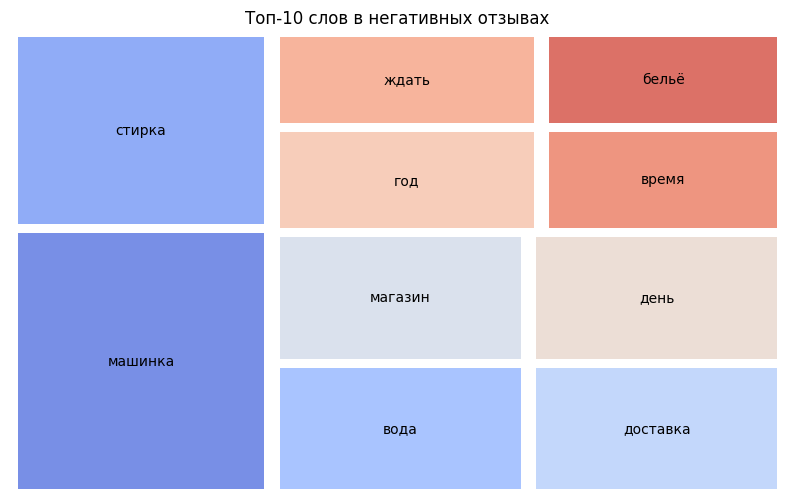

In [16]:
# Визуализация облака слов
plt.figure(figsize=(10, 6))
squarify.plot(sizes=wc['pct_total'], label=wc['word'], alpha=.8,
              pad=2, color=sns.color_palette('coolwarm', n_colors=len(wc)))
plt.axis('off')
plt.title('Топ-10 слов в негативных отзывах')
plt.show()

/var/folders/hn/x02j7qt55vq1pfgg66l198p00000gn/T/ipykernel_39341/3461036727.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette='coolwarm').set(title="Количество слов");


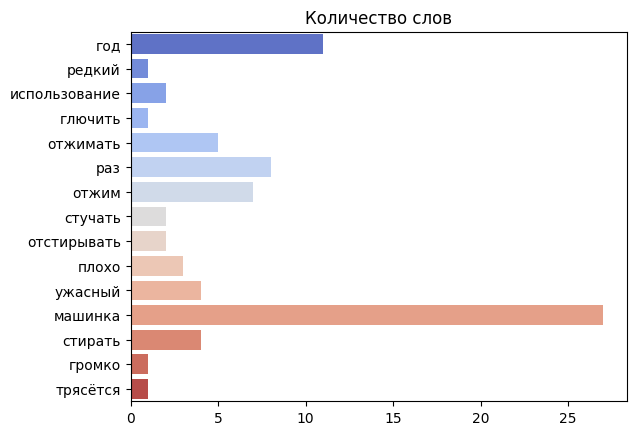

In [17]:
x = list(word_counts.keys())[:15]
y = list(word_counts.values())[:15]
sns.barplot(x=y, y=x, palette='coolwarm').set(title="Количество слов");


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


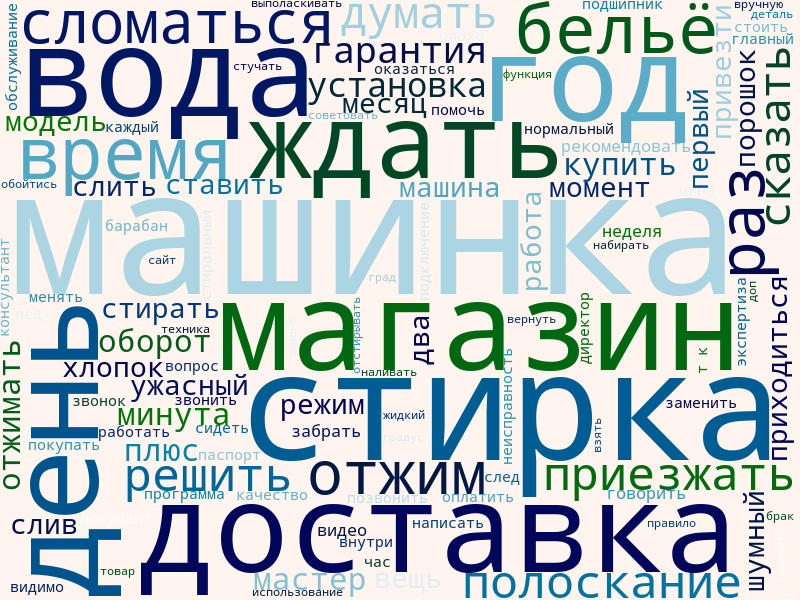

In [20]:
!pip3 install wordcloud

from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
wcl = WordCloud(width=800,
height=600,
min_font_size=12,
background_color="#fff5ee",
colormap="ocean")
wcl.generate_from_text(" ".join(negative_tokens))
wcl.to_image()

In [21]:
new_reviews = ["С рождением ребёнка эта машина моя помощница уже как 3 года, ежедневное использование по 2-3 стирки в день. До сих пор в идельном состоянии. Простирает вещи, прополаскивает идеально. 13 режимов работы для меня достаточно. Бюджетный вариант, а ничем не хуже дорогих стиральных машин", "Пока не пожалели, стирает отлично , очень хорошо выполаскивает . Соответствует цена-качество."]
processed_new_reviews = [preprocess_text(review) for review in new_reviews]
new_reviews_vectorized = vectorizer.transform(processed_new_reviews)

In [22]:
predictions = model.predict(new_reviews_vectorized)
print(predictions)

[1 1]
